# SMEB Transformation to OpenFOAM Code (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import sympy

from zoomy_jax.fvm.solver_jax import Settings
from zoomy_core.model.models.shallow_moments_topo import ShallowMomentsTopoNumerical, ShallowMomentsTopo

import zoomy_core.model.initial_conditions as IC
import zoomy_core.model.boundary_conditions as BC
from zoomy_core.misc.misc import Zstruct
import zoomy_core.transformation.to_openfoam as trafo
import zoomy_core.mesh.mesh as petscMesh


## Model definition

In [ ]:
level = 4
offset = level+1

bcs = BC.BoundaryConditions(
    [
        BC.Wall(tag="inflow", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)], wall_slip=1),
        BC.Wall(tag="outflow", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)], wall_slip=1),
        BC.Wall(tag="wall", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)], wall_slip=1),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[1] = np.where(x[0] < 5., 0.005, 0.005)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowMomentsTopo(
    level=level,
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

# the mesh is necessary to connect the boundary conditions to the mesh tags
main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_of/mesh2d.msh")
)
model.initialize_boundary_conditions(mesh)

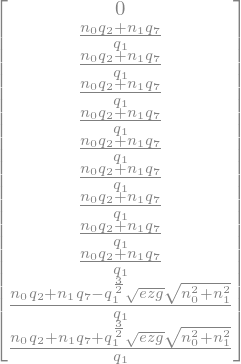

In [3]:
model.eigenvalues()

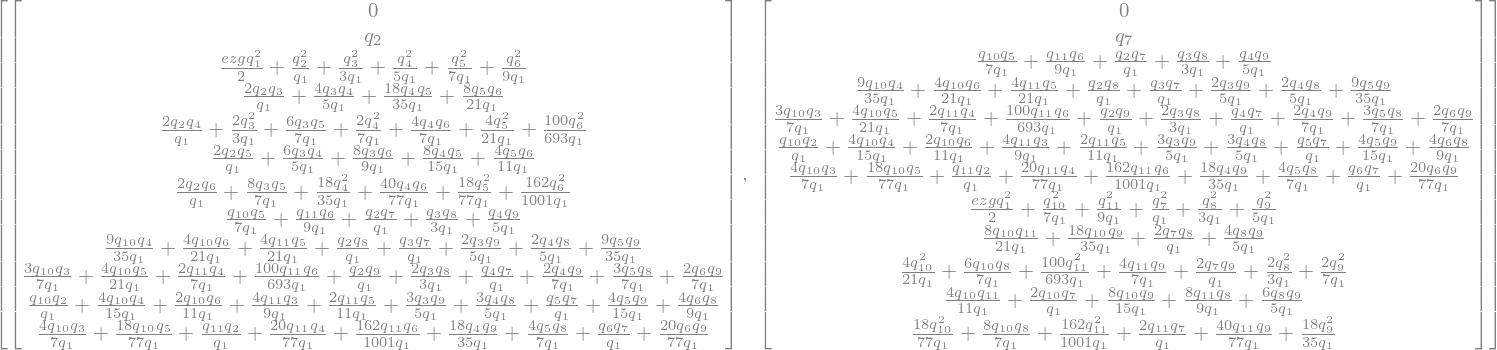

In [4]:
model.flux()

## Sympy Model

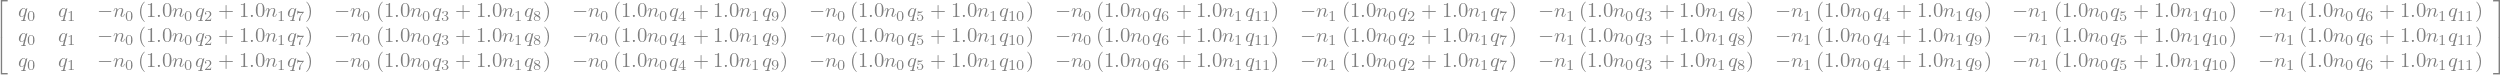

In [5]:
model.print_boundary_conditions()

## Code transformation

In [6]:
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/trafo", filename="swe.h5"))
trafo.write_code(model, settings, additional_writes=[{"name": "basis", "expression": sympy.Matrix(model.basisfunctions.basis), "arguments": ["z"]}])

2025-10-14 15:37:21.646 | WARNING  | library.core.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [7]:
model.position.as_dict()

{'X0': X0, 'X1': X1, 'X2': X2}

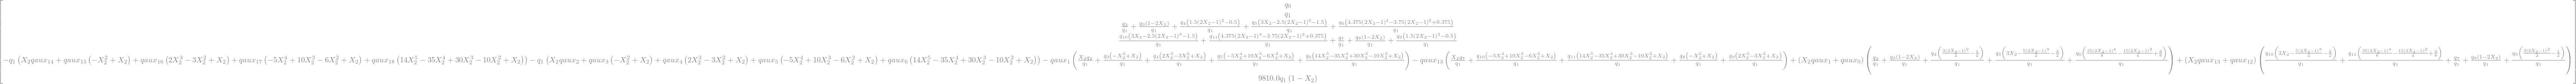

In [8]:
model.project_2d_to_3d()

## Check the output

In [9]:
main_dir = os.getenv("ZOOMY_DIR")
path = os.path.join(main_dir, os.path.join(settings.output.directory, '.foam_interface/Model.H'))
with open(path, "r") as f:
    print(f.read())


#pragma once
#include "List.H"
#include "vector.H"
#include "scalar.H"

namespace Model
{
constexpr int n_dof_q    = 12;
constexpr int n_dof_qaux = 24;
constexpr int dimension  = 2;
const Foam::List<Foam::word> map_boundary_tag_to_function_index{ "wall", "inflow", "outflow" };

inline Foam::List<Foam::List<Foam::scalar>> flux_x(
    const Foam::List<Foam::scalar>& Q,
    const Foam::List<Foam::scalar>& Qaux)
{
    auto res = Foam::List<Foam::List<Foam::scalar>>(12, Foam::List<Foam::scalar>(1, 0.0));
    Foam::scalar t0 = (1.0 / Foam::pow(Q[1], 1));
        Foam::scalar t1 = Foam::pow(Q[3], 2)*t0;
        Foam::scalar t2 = Foam::pow(Q[4], 2)*t0;
        Foam::scalar t3 = Foam::pow(Q[5], 2)*t0;
        Foam::scalar t4 = Foam::pow(Q[6], 2)*t0;
        Foam::scalar t5 = Q[2]*t0;
        Foam::scalar t6 = 2*t5;
        Foam::scalar t7 = Q[4]*t0;
        Foam::scalar t8 = Q[3]*t7;
        Foam::scalar t9 = Q[5]*t7;
        Foam::scalar t10 = Q[5]*t0;
        Foam::scalar t11 = Q[6]*t10;
    